In [124]:
"""
Algorithm for finding the maximum inscribed circle inside an arbitrary 2D binary mask
https://blog.mapbox.com/a-new-algorithm-for-finding-a-visual-center-of-a-polygon-7c77e6492fbc

Input:
    mask -- binary numpy mask (1-inside; 0-outside)
Output:
    c, r -- center, radius

0. kdtree = get all boundary points
1. generate initial cells
2. 
max_dist = -INF
pq = PriorityQueue()
while (!pq.empty()) {
    cell = pq.pop()
    dist = kdtree.dist(cell.center())
    if (map[cell.center()] == 0) dist = -dist

    potential_dist = cell.radius() + dist
    if (potential_dist > max_dist) {
        max_dist = potential_dist
        c1, c2, c3, c4 = cell.subdivide()
        if (c1.radius() > EPS) {
            pq.push(c1); pq.push(c2); pq.push(c3); pq.push(c4)
        }
    }
}
"""
from queue import Queue

import cv2
import numpy as np
from scipy.spatial import KDTree

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'text.color': 'grey'})
matplotlib.rcParams.update({'font.size': 6})

from utils import *

class Cell:
    def __init__(self, x1, y1, x2, y2):
        self.x1 = x1; self.x2 = x2; self.y1 = y1; self.y2 = y2
        self.center = ((y1 + y2) / 2.0, (x1 + x2) / 2.0)
        self.radius = np.sqrt(2.0) * (x2 - x1) / 2.0

    def subdivide(self):
        x1, y1, x2, y2 = self.x1, self.y1, self.x2, self.y2
        size = (self.x2 - self.x1) / 2.0
        c1 = Cell(x1, y1, x1 + size, y1 + size)
        c2 = Cell(x1 + size, y1, x2, y1 + size)
        c3 = Cell(x1, y1 + size, x1 + size, y2)
        c4 = Cell(x1 + size, y1 + size, x2, y2)
        return c1, c2, c3, c4
    

def initCells(shape):
    h, w = shape
    size = min(h, w) / 4.0
    nw = int(w / size)
    nh = int(h / size)
    dw = (w - nw * size) / 2.0
    dh = (h - nh * size) / 2.0
    cells = []
    for x1 in np.arange(dw, w - dw, size):
        for y1 in np.arange(dh, h - dh, size):
            x2 = x1 + size
            y2 = y1 + size
            if x2 > w or y2 > h: continue
            cells.append(Cell(x1, y1, x2, y2))
    return cells


def getBoundaryPoints(mask):
    """
    ret: [(y1, x1), (y2, x2), ...]
    """
    _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    ret = []
    for c in contours: 
        for p in c: ret.append(p[0][::-1])
    return ret


def maxInscribedCircle(mask, EPS=1e-4, return_cells=False):
    cells = initCells(mask.shape)
    boundpts = getBoundaryPoints(mask)
    kdtree = KDTree(boundpts)

    max_dist = 0
    max_center = None

    q = Queue()
    for cell in cells: q.put(cell)
    all_cells = []

    while not q.empty():
        cell = q.get()
        [dist], _ = kdtree.query([cell.center])
        y, x = cell.center
        if mask[int(y), int(x)] == 0: dist = -dist

        potential_dist = cell.radius + dist
        if potential_dist + EPS < max_dist: continue
        
        if dist > max_dist: 
            max_dist, max_center = dist, cell.center

        for c in cell.subdivide():
            if c.radius > EPS: q.put(c)
                
        if return_cells: all_cells.append(cell)
    
    ret = (max_center, max_dist)
    if return_cells: ret = (ret, all_cells)
    return ret

In [125]:
def drawBg(img, dpi=100):
    fig = plt.figure(dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    if img is not None: 
        if len(img.shape) == 2: 
            img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
        plt.imshow(img[:, :, ::-1])
        
def showEq():
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

def drawCells(cells, img=None, dpi=100):
    drawBg(img, dpi)
    for c in cells:
        plt.plot([c.x1, c.x1], [c.y1, c.y2])
        plt.plot([c.x1, c.x2], [c.y2, c.y2])
        plt.plot([c.x2, c.x2], [c.y1, c.y2])
        plt.plot([c.x1, c.x2], [c.y1, c.y1])
    showEq()
    
def drawBoundaryPoints(boundpts, img=None, dpi=100):
    img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
    for y, x in boundpts: cv2.circle(img, (x, y), 3, (0, 0, 255))
    drawBg(img, dpi)
    showEq()
    
def drawCircle(circle, img=None, cells=[], dpi=100):
    (y, x), r = circle
    img = np.repeat(img[:, :, np.newaxis], 3, axis=-1)
    cv2.circle(img, (int(x), int(y)), int(r), (0, 0, 255), -1)
    drawCells(cells, img, dpi)

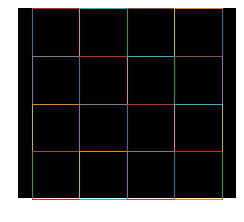

In [126]:
drawCells(initCells([350, 400]), img=np.zeros([350, 400]), dpi=50)

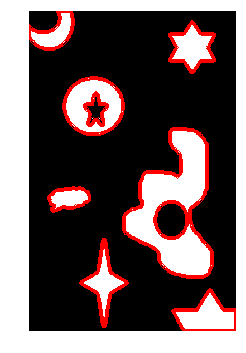

In [127]:
mask = cv2.imread('/home/zzp/mask.png', 0)
boundpts = getBoundaryPoints(mask)
drawBoundaryPoints(boundpts, mask, dpi=80)

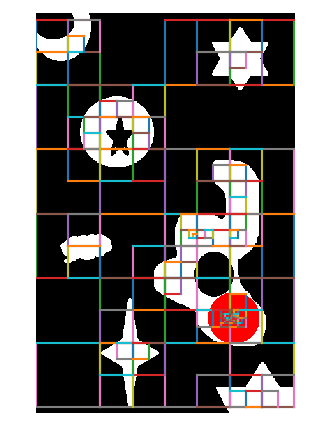

In [128]:
circle, cells = maxInscribedCircle(mask, return_cells=True)
drawCircle(circle, mask, cells, dpi=100)